# Transfer labels from scRNA-seq using scVI
**Author**: Adam Klie (last modified: 10/12/2023)<br>
***
**Description**: This script (currently on a single sample)

# Set-up

In [2]:
# Imports
import scanpy as sc
import scvi
import numpy as np
import snapatac2 as snap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [54]:
# Load in the AnnData objects for RNA and ATAC
rna_sample = "H1-D39"
atac_sample = "MM290"
reference = sc.read_h5ad(f"/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellcommander/{rna_sample}/annotate/publication/annotated.h5ad")
query = sc.read_h5ad(f"/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/25Oct23/snapatac2/cellcommander_recipe/{atac_sample}/gene_matrix.h5ad")

In [3]:
# Concatenate reference and query datasets, note this just slaps the matrices together
data = reference.concatenate(query, batch_categories=["reference", "query"])
data

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/anndata/_core/merge.py:1348: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


AnnData object with n_obs × n_vars = 8319 × 23436
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden', 'initial_leiden_1', 'cellid', 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden_1', 'batch'
    var: 'n_cells-query', 'gene_ids-reference', 'feature_types-reference', 'genome-reference', 'mt-reference', 'ribo-reference', 'n_cells_by_counts-reference', 'mean_counts-reference', 'log1p_mean_counts-reference', 'pct_dropout_by_counts-reference', 'total_counts-reference', 'log1p_total_counts-reference', 'sctransform_genes-reference'
    obsm: 'X_umap'

In [4]:
# Get batch aware highly variable genes
data.layers["counts"] = data.X.copy()
sc.pp.filter_genes(data, min_cells=5)
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(
    data,
    n_top_genes = 5000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="batch",
    subset=True
)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [8]:
# Set up the AnnData and the model
scvi.model.SCVI.setup_anndata(data, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(
    data,
    n_layers=2,
    n_latent=30,
    gene_likelihood="nb",
    dispersion="gene-batch",
)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [9]:
# Train with early stopping
vae.train(max_epochs=1000, early_stopping=True)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
LOCAL_RANK: 0 - CU

Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 388/1000:  39%|███▉      | 388/1000 [04:00<06:19,  1.61it/s, v_num=1, train_loss_step=2.6e+3, train_loss_epoch=2.64e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2680.245. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

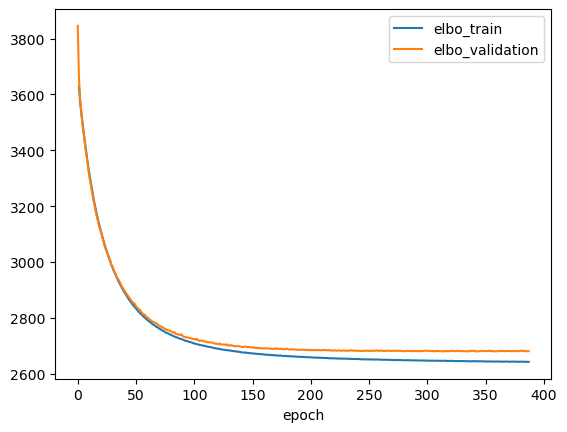

In [10]:
# Check the loss
ax = vae.history['elbo_train'][1:].plot()
vae.history['elbo_validation'].plot(ax=ax)

In [18]:
# Set-up for scANVI which uses cell type labels
data.obs["cellid_scanvi"] = 'Unknown'
ref_idx = data.obs['batch'] == "reference"
data.obs["cellid_scanvi"][ref_idx] = data.obs['cellid'][ref_idx]

/tmp/ipykernel_3796911/1916779941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs["cellid_scanvi"][ref_idx] = data.obs['cellid'][ref_idx]


In [20]:
# Set up the model
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=data,
    labels_key="cellid_scanvi",
    unlabeled_category="Unknown",
)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [21]:
# Train it with no early stopping
lvae.train(max_epochs=1000, n_samples_per_label=100)

INFO     Training for 1000 epochs.                                                                                 


/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
LOCAL_RANK: 0 - CU

Epoch 1000/1000: 100%|██████████| 1000/1000 [19:16<00:00,  1.18s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.69e+3]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [19:16<00:00,  1.16s/it, v_num=1, train_loss_step=2.71e+3, train_loss_epoch=2.69e+3]


<Axes: xlabel='epoch'>

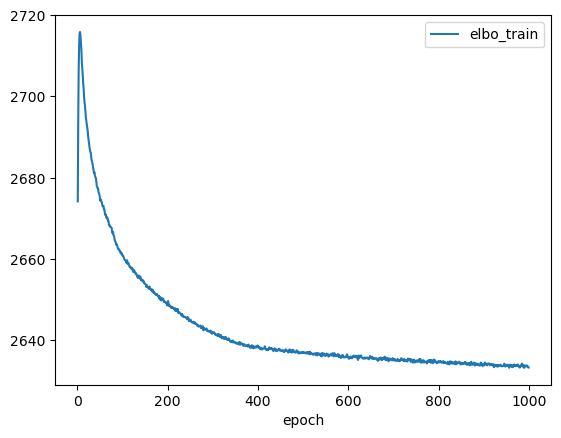

In [25]:
# Check the loss curve
lvae.history['elbo_train'][1:].plot()

In [26]:
# Transfer labels
data.obs["C_scANVI"] = lvae.predict(data)
data.obsm["X_scANVI"] = lvae.get_latent_representation(data)

In [27]:
# Calc UMAP
sc.pp.neighbors(data, use_rep="X_scANVI")
sc.tl.umap(data)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/m

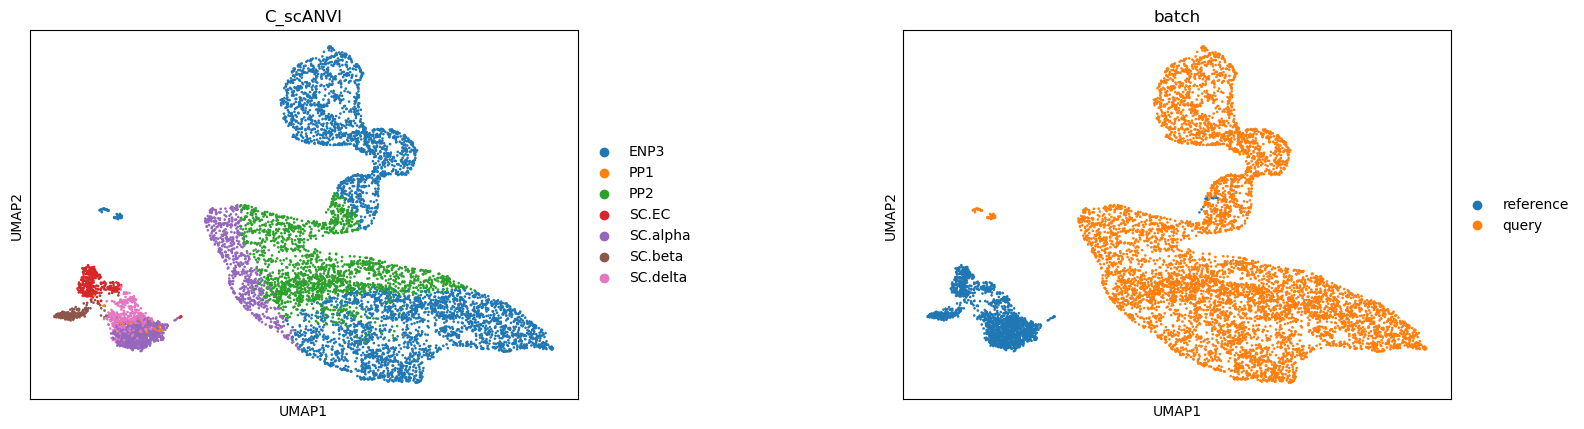

In [28]:
# Plot UMAP
sc.pl.umap(data, color=['C_scANVI', "batch"], wspace=0.45)

In [37]:
# Load in the original ATAC to get clusters
atac = sc.read_h5ad("/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/25Oct23/snapatac2/cellcommander_recipe/MM290/clustered.h5ad")

In [38]:
# Add the cellid to this object
obs = data.obs
obs = obs[obs['batch'] == 'query']
obs.index = list(map(lambda x: x.split("-query")[0], obs.index))
atac.obs['cellid'] = obs.loc[atac.obs.index]['C_scANVI']

In [40]:
# Create a heatmap of the cell type proportions in each cluster
cellid_labels = np.unique(atac.obs['cellid'])

count_table = {}
for cl, ct in zip(atac.obs['leiden_1'], atac.obs['cellid']):
    if cl in count_table:
        count_table[cl].append(ct)
    else:
        count_table[cl] = [ct]

mat = []
for cl, counts in count_table.items():
    c = Counter(counts)
    c = np.array([c[ct] for ct in cellid_labels])
    c = c / c.sum()
    mat.append(c)

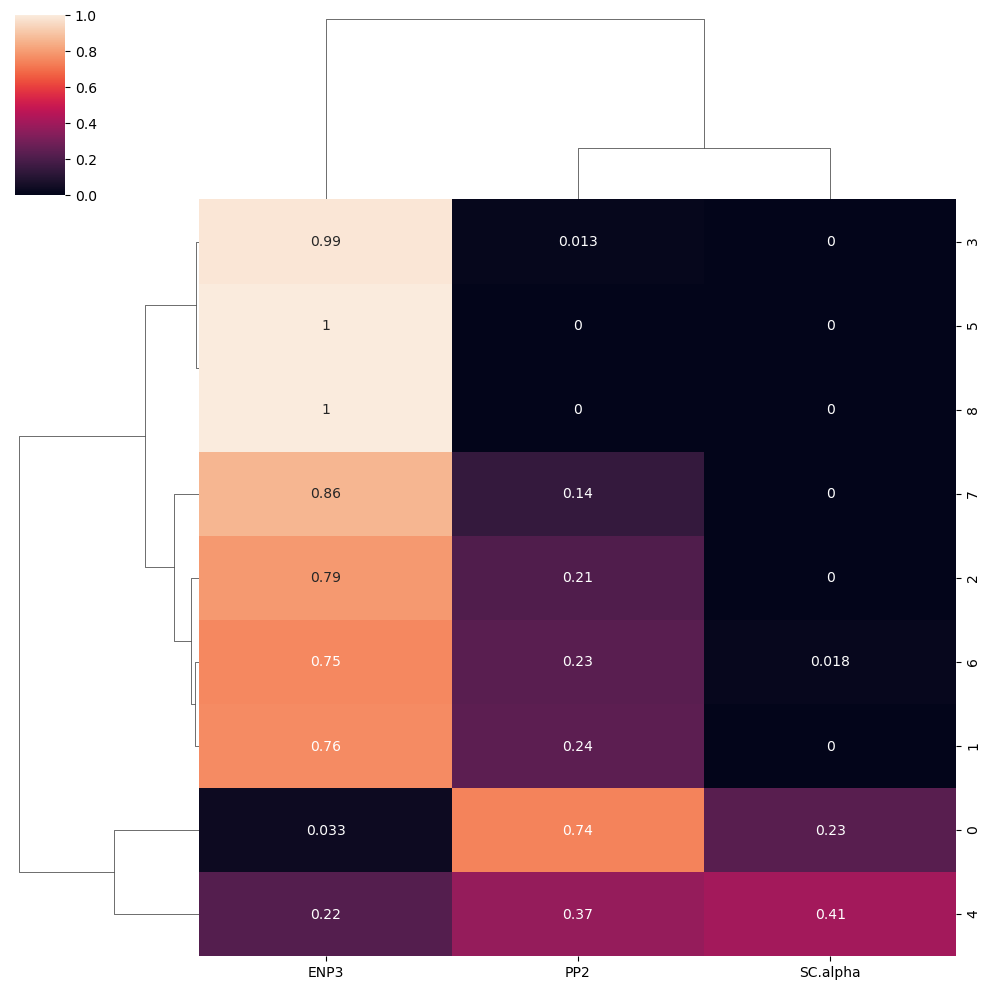

In [43]:
# Plot it
df_cm = pd.DataFrame(
    mat,
    index = count_table.keys(),
    columns = cellid_labels,
)
sns.clustermap(df_cm, annot=True)

# DONE!

---